In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
from constants import *

os.makedirs('./images', exist_ok=True)

We read in the data, but we treat video durations and publish dates of 0 as NaN since 0 length videos or videos published on YouTube in 1970 make no sense.

In [2]:
sb_data = pd.read_csv(sb_data_file, 
                      dtype=dtypes,
                      usecols=lambda col: col not in unwanted_cols,
                      # skiprows=range(1, 7_000_000),
                      # nrows = 2_000_000,
                      na_values={'videoDuration': [0],
                                 'published': [0]}
                     )
sb_data = sb_data.drop(sb_data[sb_data['category'] == 'moreCategories'].index)
sb_data['category'] = sb_data['category'].cat.remove_unused_categories()

pd.set_option('display.max_columns', None)
display(sb_data.head())

,videoID,startTime,endTime,votes,locked,userID,timeSubmitted,views,category,actionType,videoDuration,hidden,reputation,shadowHidden,channelID,title,published,isVIP
0,fBxtS9BpVWs,714.00000,763.00000,64,False,38e7c2af-09f4-4492-bf49-75e443962ccd,1.564089e+09,386,sponsor,skip,NaN,0,0.0,False,UCXuqSBlHAE6Xw-yeJA0Tunw,Really Stupid & Expensive Gaming Setup!,1.529539e+09,False
1,FfgT6zx4k3Q,446.51013,513.39233,225,False,38e7c2af-09f4-4492-bf49-75e443962ccd,1.564089e+09,3222,sponsor,skip,NaN,1,0.0,False,UCsXVk37bltHxD1rDPwtNM8Q,Could Your Phone Hurt You? Electromagnetic Pol...,1.562458e+09,False
2,9P6rdqiybaw,488.52150,542.11035,-2,False,38e7c2af-09f4-4492-bf49-75e443962ccd,1.564089e+09,25661,sponsor,skip,552.0,0,0.0,False,UCsXVk37bltHxD1rDPwtNM8Q,Wormholes Explained – Breaking Spacetime,1.534032e+09,False
3,UjtOGPJ0URM,497.14310,569.15330,-2,False,38e7c2af-09f4-4492-bf49-75e443962ccd,1.564089e+09,24217,sponsor,skip,NaN,0,0.0,False,UCsXVk37bltHxD1rDPwtNM8Q,Why Alien Life Would be our Doom - The Great F...,1.517443e+09,False
4,fBxtS9BpVWs,41.00000,53.00000,115,False,38e7c2af-09f4-4492-bf49-75e443962ccd,1.564089e+09,768,sponsor,skip,NaN,0,0.0,False,UCXuqSBlHAE6Xw-yeJA0Tunw,Really Stupid & Expensive Gaming Setup!,1.529539e+09,False


In [3]:
pd.set_option('display.float_format', '{:.0f}'.format)
sb_data.describe()

,startTime,endTime,votes,timeSubmitted,views,videoDuration,hidden,reputation,published
count,15334918,15334918,15334918,15334918,15334918,13946917,15334918,15334860,5128541
mean,935,984,0,1669915610,409,2363,0,2,1601298058
std,17696,20309,9,34826418,3498,8889,1,6,80372325
min,-244,-64,-501,1564088877,0,0,0,-2,1130284800
25%,16,50,0,1649939788,0,516,0,0,1582675200
50%,192,236,0,1663173396,19,958,0,0,1635724800
75%,764,803,0,1697308372,142,2228,0,0,1651622400
max,38378560,38400680,9993,1732593103,1581931,25335278,2,27,1712966400


From the above table we notice a few main issues to acount for later.

- Missing video durations: We need a way to resolve this whilst still having endTime be less than video duration for EVERY video.
    - One strategy to handle this is to check all videoIDs for the maximum endTime and then scaling with the median videoDuration/endTime ratio for that videoID.
    - Alternatively we can impute with ignore, but we'd like to scale startTime and endTime relative to the videoDuration.
- Missing published dates prevent us from calculated the difference between timeSubmitted and time published.
    - This can be easily resolved by calculated the difference and then imputing with the median.

## Class Frequencies
We aim to build a classifier with the target as the segment category. Here is a look at the frequency of those categories.

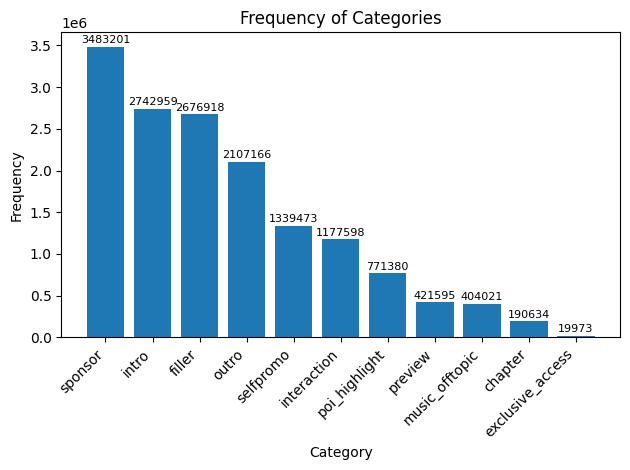

In [4]:
category_counts = sb_data['category'].value_counts()

fig, ax = plt.subplots()
bars = ax.bar(category_counts.index, category_counts.values)

# Label each bar with the count
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, height + 0.005 * max(category_counts.values), str(height), ha='center', va='bottom', fontsize=8)

# Add labels and title
ax.set_xlabel('Category')
ax.set_ylabel('Frequency')
ax.set_title('Frequency of Categories')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig(f'./images/{ax.get_title()}.png')
plt.show()

## Missing Data

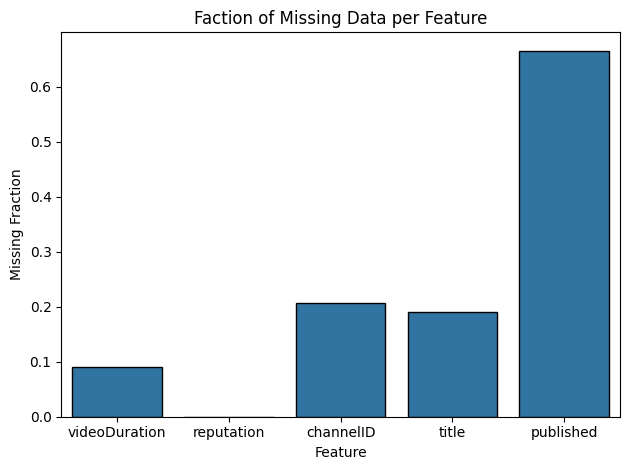

In [5]:
attributes_missing_data = ['videoDuration', 'reputation', 'channelID', 'title', 'published']
missing_fraction = sb_data[attributes_missing_data].isnull().mean().reset_index()
missing_fraction.columns = ['Feature', 'MissingFraction']

sns.barplot(data=missing_fraction, x='Feature', y='MissingFraction', edgecolor='black')
plt.title('Faction of Missing Data per Feature')
plt.ylabel('Missing Fraction')
plt.tight_layout()

plt.savefig(f'./images/{plt.gca().get_title()}.png')
plt.show()

Title and channelID are of no real consequence to use, but videoDuration and publish date are.

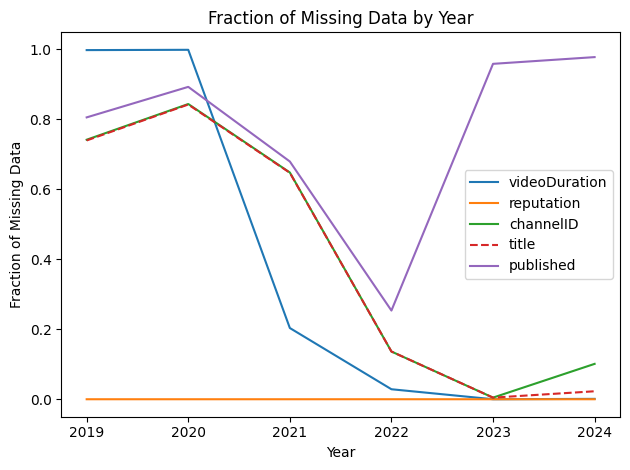

In [6]:
sb_data['year'] = pd.to_datetime(sb_data['timeSubmitted'], unit='s').dt.year

missing_fraction_by_year = sb_data[attributes_missing_data+['year']].groupby('year').apply(lambda x: x.isna().mean(), include_groups=False)
missing_fraction_by_year = missing_fraction_by_year.replace(0, 1e-10)

for column in missing_fraction_by_year.columns:
    linestyle = '--' if column == 'title' else 'solid'
    plt.plot(missing_fraction_by_year.index, missing_fraction_by_year[column], label=column, linestyle=linestyle)

# plt.yscale('log') 
plt.xlabel('Year')
plt.ylabel('Fraction of Missing Data')
plt.title('Fraction of Missing Data by Year')
plt.legend()
plt.tight_layout()

plt.savefig(f'./images/{plt.gca().get_title()}.png')
plt.show()

## Feature Engineering

There are a few features that we believe will be useful.

- segmentDuration (endTime-startTime)
- scaledStart (startTime/videoDuration)
- scaledEnd (endTime/videoDuration)
- scaledSegmentDuration (segmentDuraction/videoDuration)
- timeToSubmission (timeSubmitted - published)

In [7]:
sb_data['segmentDuration'] = sb_data['endTime']-sb_data['startTime']
sb_data['scaledStart'] = sb_data['startTime']/sb_data['videoDuration']
sb_data['scaledEnd'] = sb_data['endTime']/sb_data['videoDuration']
sb_data['scaledSegmentDuration'] = sb_data['segmentDuration']/sb_data['videoDuration']
sb_data['timeToSubmission'] = sb_data['timeSubmitted']-sb_data['published']

Now to plot histograms of all the numerical data. We need to cut out the top 1% of data in order to make these plots legible.

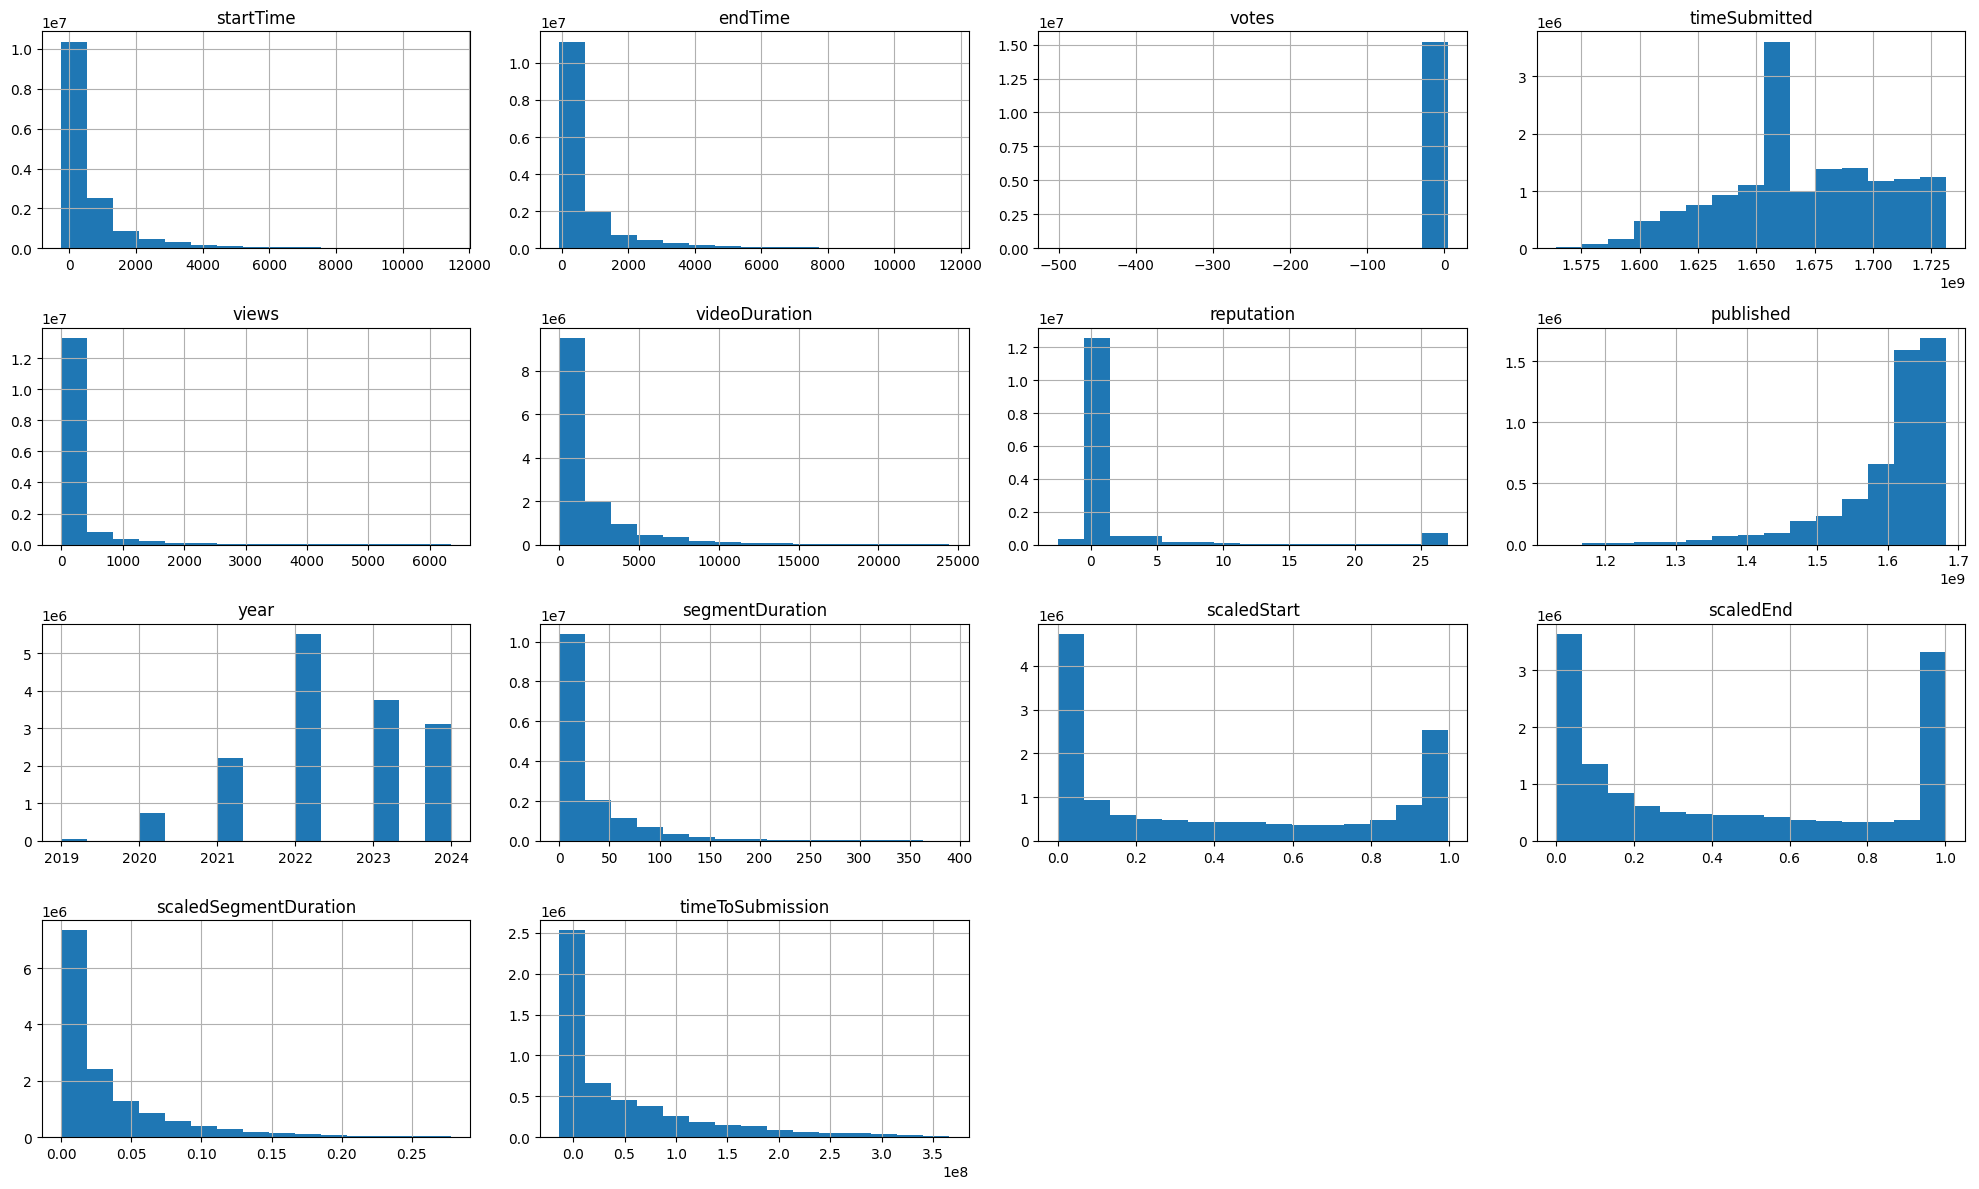

In [8]:
numerical_data = sb_data.select_dtypes(include=['number']).drop(columns=['hidden'])

numerical_data = numerical_data[(numerical_data >= numerical_data.quantile(0.0)) & (numerical_data <= numerical_data.quantile(0.99))]
numerical_data.hist(bins=15 ,figsize=(20,12))
plt.tight_layout()

plt.savefig(f'./images/histograms.png')
plt.show()

Using ```pandas.plotting.scatter_matrix``` with this many data points is computationaly expensive taking nearly 30 minutes for 2M data points. We will skip this in favour if a correleation matrix and a heatmap of that.

For the correlation matrix, I encode the category feature using a onehot encoding so we can see how the other features correlate to them. I cut off the right side of the matrix because the upper right section is just a duplicate of the lower left, and the lower right is the correleation between categories which are mutually exclusive.

## Visualizing Correlations

In [9]:
encoded = pd.get_dummies(sb_data['category'])
numerical_columns = ["timeSubmitted", "published", "timeToSubmission", "startTime", "endTime", "segmentDuration", "scaledStart", "scaledEnd", "scaledSegmentDuration", "videoDuration", "views", "reputation", "votes"]
boolean_like_columns = ['hidden', 'shadowHidden', 'locked', 'isVIP']
# Combine with numerical data
combined = pd.concat([sb_data[numerical_columns+boolean_like_columns], encoded], axis=1)

# Correlation matrix
correlation_matrix = combined.corr()

def highlight_correlations(val, threshold=0.1, cap=1):
    if val > threshold and val < cap:
        color = 'background-color: lightgreen'  # Positive correlation
    elif val < -threshold:
        color = 'background-color: lightcoral'  # Negative correlation
    else:
        color = ''
    return color

#display(correlation_matrix)
left_matrix = correlation_matrix.iloc[:,:17]
# styled_left_matrix = left_matrix.style.map(highlight_correlations)
# display(styled_left_matrix)

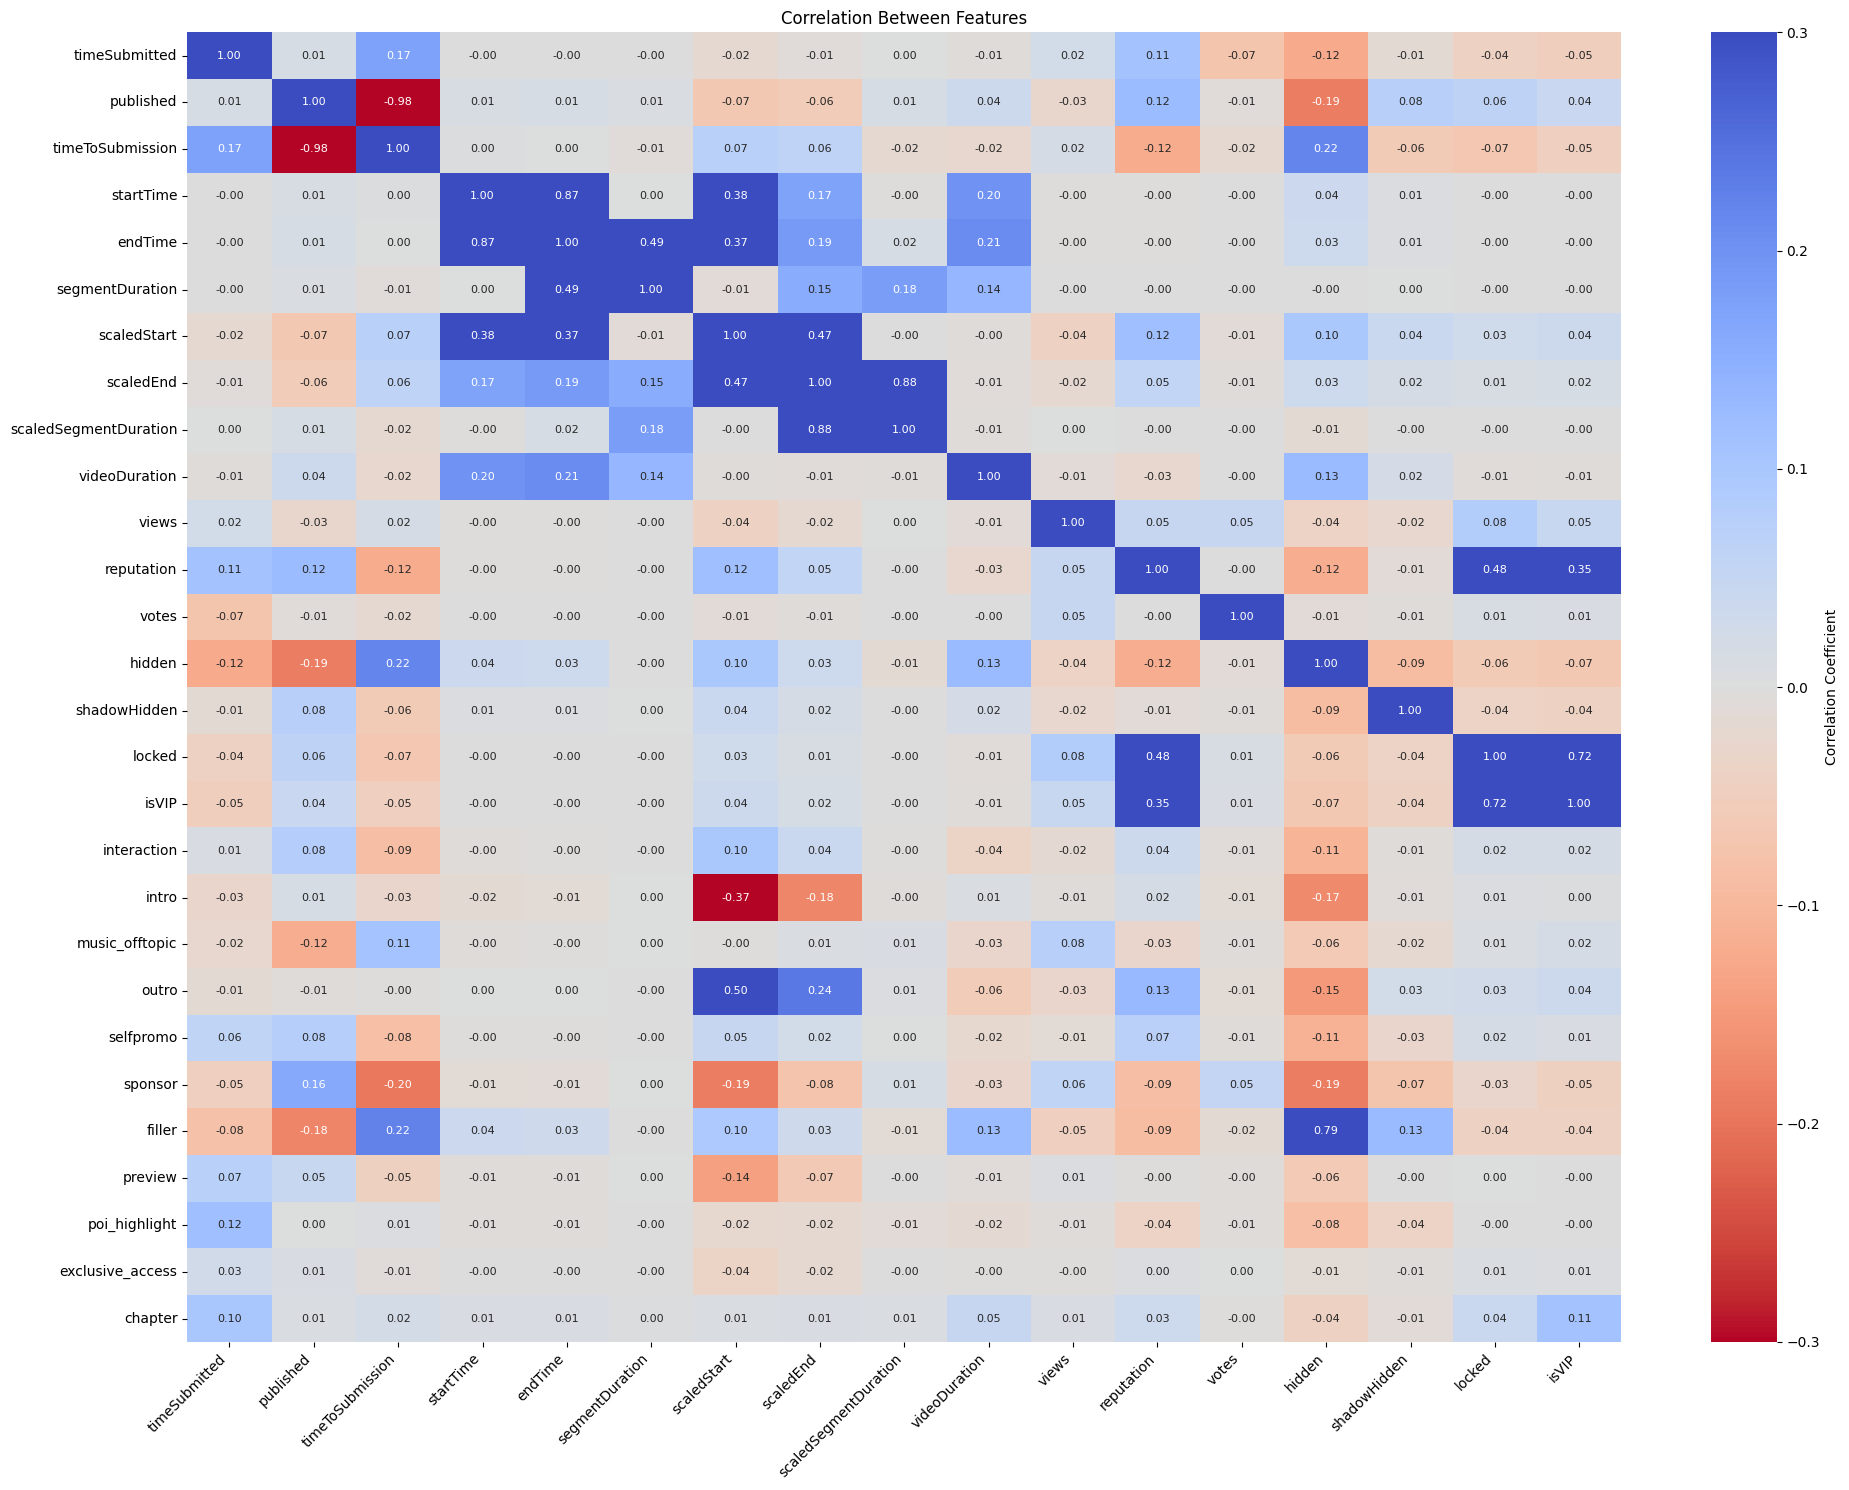

In [10]:
plt.figure(figsize=(20, 15))
sns.heatmap(left_matrix.apply(pd.to_numeric, errors='coerce'), cmap='coolwarm_r', vmin=-0.3, vmax=0.3, cbar_kws={'label': 'Correlation Coefficient'}, annot=True, fmt=".2f", annot_kws={"size": 8})
plt.title('Correlation Between Features')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

plt.savefig(f'./images/{plt.gca().get_title()}.png')
plt.show()

In [11]:
from scipy.stats import f_oneway

categories = sb_data['category'].unique()
# Group numerical data by categories
for num_col in numerical_columns+boolean_like_columns:
    df_clean = sb_data.dropna(subset=['category', num_col])
    groups = (df_clean[df_clean['category'] == category][num_col] 
              for category in categories)
    # Perform ANOVA
    f_stat, p_value = f_oneway(*groups)
    print(num_col)
    print(f"\tF-statistic: {f_stat}, p-value: {p_value}")

timeSubmitted
	F-statistic: 66007.50205723483, p-value: 0.0
published
	F-statistic: 37998.053614825, p-value: 0.0
timeToSubmission
	F-statistic: 51692.068892359704, p-value: 0.0
startTime
	F-statistic: 2705.633741824661, p-value: 0.0
endTime
	F-statistic: 2033.441551981309, p-value: 0.0
segmentDuration
	F-statistic: 23.59656246584717, p-value: 4.819427826344096e-45
scaledStart
	F-statistic: 914368.3358070954, p-value: 0.0
scaledEnd
	F-statistic: 134428.13310647497, p-value: 0.0
scaledSegmentDuration
	F-statistic: 964.4469845974716, p-value: 0.0
videoDuration
	F-statistic: 31175.966312780867, p-value: 0.0
views
	F-statistic: 18294.282580395833, p-value: 0.0
reputation
	F-statistic: 58835.45456412425, p-value: 0.0
votes
	F-statistic: 4289.546068179415, p-value: 0.0
hidden
	F-statistic: 2527881.9189122957, p-value: 0.0
shadowHidden
	F-statistic: 33197.28764899811, p-value: 0.0
locked
	F-statistic: 7842.560515896187, p-value: 0.0
isVIP
	F-statistic: 26908.735039989693, p-value: 0.0


A high F-statistic here tells us that at least one of the target categories in distinghuishable from the others with respect to that feature as there is more variation between categories than there is variation within a category. This bodes well for classification. Though we don't know which categories this favours.

Here I want to look at the relationskip between actionType (our other categorical feature) and category.

In [12]:
contingency_table = pd.crosstab(sb_data['actionType'],sb_data['category'])
normalized = contingency_table.div(contingency_table.sum(axis=0), axis=1)

# sns.heatmap(normalized, cmap='coolwarm', vmin=0, vmax=1)
# plt.title('Fraction of Action Type per Category')
# plt.show()

def highlight_correlations(val, threshold=0.1, cap=2):
    if val > threshold and val < cap:
        color = 'background-color: lightgreen'  # Positive correlation
    elif val > threshold:
        color = 'background-color: green'  # Negative correlation
    else:
        color = ''
    return color

styled_table = normalized.style.map(lambda x: highlight_correlations(x,0.0,0.2))
display(styled_table)

category,interaction,intro,music_offtopic,outro,selfpromo,sponsor,filler,preview,poi_highlight,exclusive_access,chapter
actionType,,,,,,,,,,,
skip,0.995701,0.999397,0.999995,0.999292,0.979024,0.982671,0.998242,0.999205,0.000000,0.000000,0.000000
poi,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
mute,0.004299,0.000603,0.000005,0.000708,0.003401,0.001716,0.001758,0.000795,0.000000,0.000000,0.000000
full,0.000000,0.000000,0.000000,0.000000,0.017576,0.015613,0.000000,0.000000,0.000000,1.000000,0.000000
chapter,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000


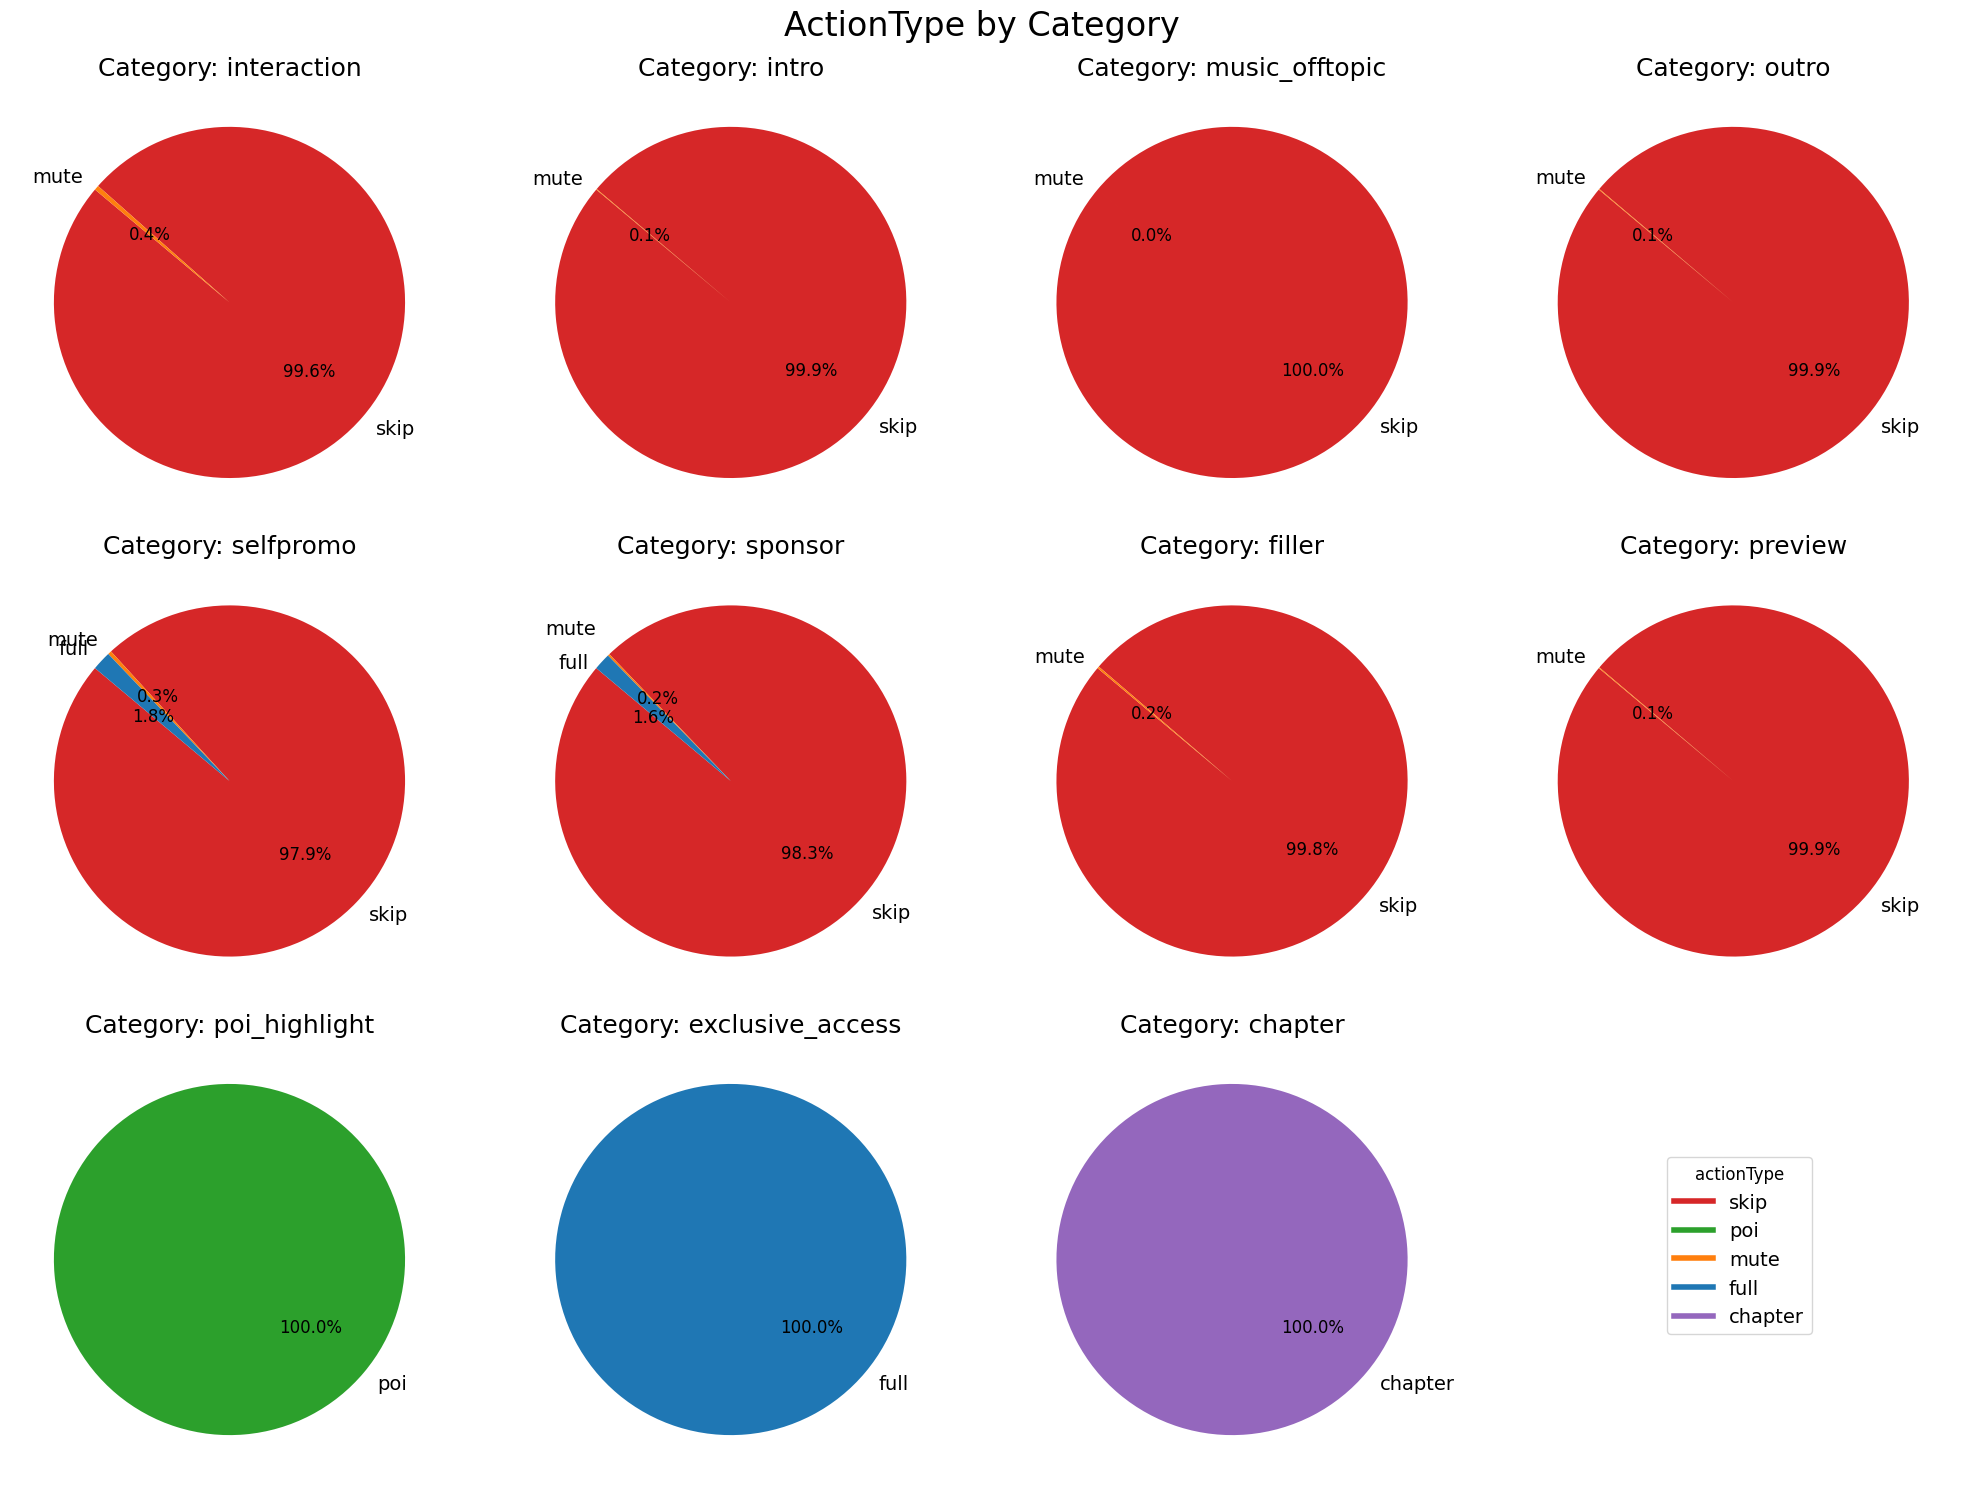

In [13]:
num_columns = len(contingency_table.columns)

fig, axes = plt.subplots(3, 4, figsize=(20, 15))
axes = axes.flatten() # to index subplots in 1D from 0 to 11 instead

labels = contingency_table.index

define_colors = {
    'full': '#1f77b4',      # Blue
    'mute': '#ff7f0e',      # Orange
    'poi': '#2ca02c',       # Green
    'skip': '#d62728',      # Red
    'chapter': '#9467bd'    # Purple
}
colors = [define_colors[label] for label in labels]

# Plot each pie chart in a subplot
for idx, column in enumerate(contingency_table.columns):
    ax = axes[idx]

    data = contingency_table[column]
    non_zero_data = data[data > 0]
    # We need to manually adjust colours for consistency and the legend.
    non_zero_colors = [colors[labels.get_loc(label)] for label in non_zero_data.index]
    
    wedges, texts, autotexts = ax.pie(
        non_zero_data,
        labels=non_zero_data.index,
        autopct='%1.1f%%',
        startangle=140,
        colors=non_zero_colors,
    )

    # Adjust the texts to be more legible
    for text in texts:
        text.set_fontsize(14)
    for i, text in enumerate(texts):
        for j in range(i + 1, len(texts)):
            if abs(text.get_position()[0] - texts[j].get_position()[0]) < 0.05 and abs(text.get_position()[1] - texts[j].get_position()[1]) < 0.05:
                text.set_position((text.get_position()[0], text.get_position()[1] * 1.1))
                texts[j].set_position((texts[j].get_position()[0], texts[j].get_position()[1] * 0.9))
    for autotext in autotexts:
        autotext.set_fontsize(12)
    for i, autotext in enumerate(autotexts):
        for j in range(i + 1, len(autotexts)):
            if abs(autotext.get_position()[0] - autotexts[j].get_position()[0]) < 0.05 and abs(autotext.get_position()[1] - autotexts[j].get_position()[1]) < 0.05:
                autotext.set_position((autotext.get_position()[0], autotext.get_position()[1] * 1.1))
                autotexts[j].set_position((autotexts[j].get_position()[0], autotexts[j].get_position()[1] * 0.9))

    ax.set_title(f'Category: {column}',fontsize=18)

# Remove any extra subplots that are not needed
for i in range(num_columns, len(axes)):
    fig.delaxes(axes[i])

# I'll just make my own legend! (this hacks around the issues I was having)
fig.legend([plt.Line2D([0], [0], color=define_colors[label], lw=4) for label in labels], labels, loc='lower right', bbox_to_anchor=(0.92, 0.1), fontsize=14,title='actionType', title_fontsize=12)

# Adjust layout for better spacing
fig.suptitle('ActionType by Category', fontsize=24, y=0.99)
plt.tight_layout()

plt.savefig(f'./images/actionType by Category.png')
plt.show()

We can see that 3 categories are completed a specific actionType. Moreover, chapter and poi_highlight are uniquely identified by that actionType.

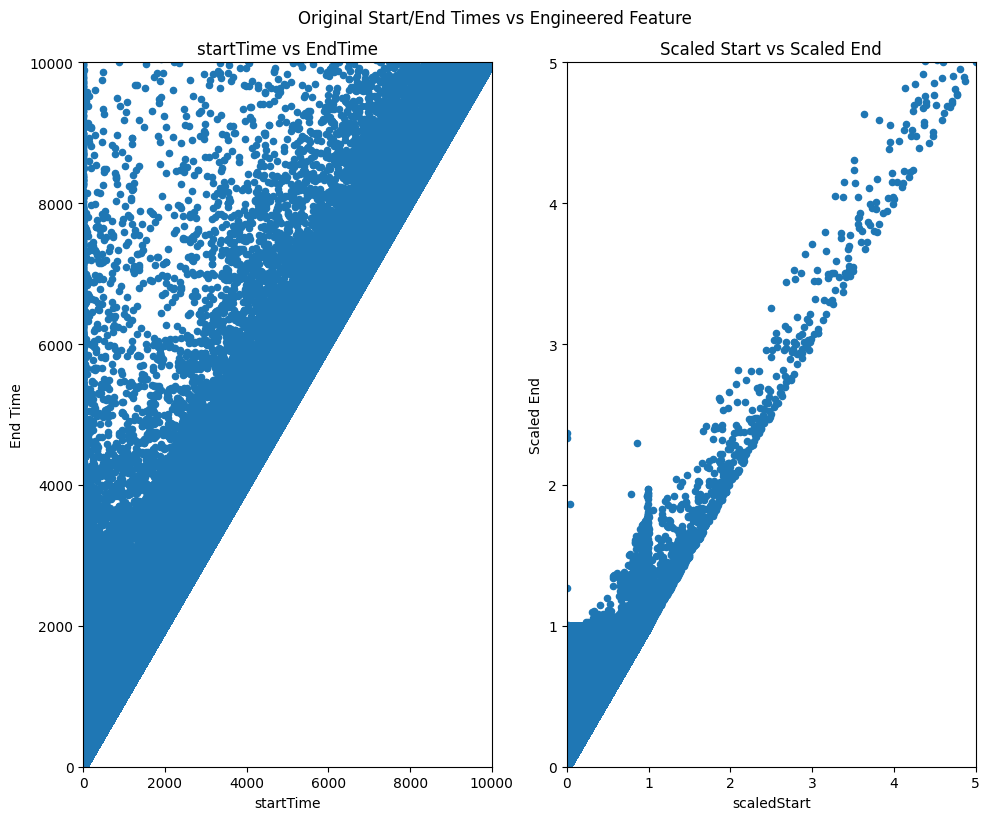

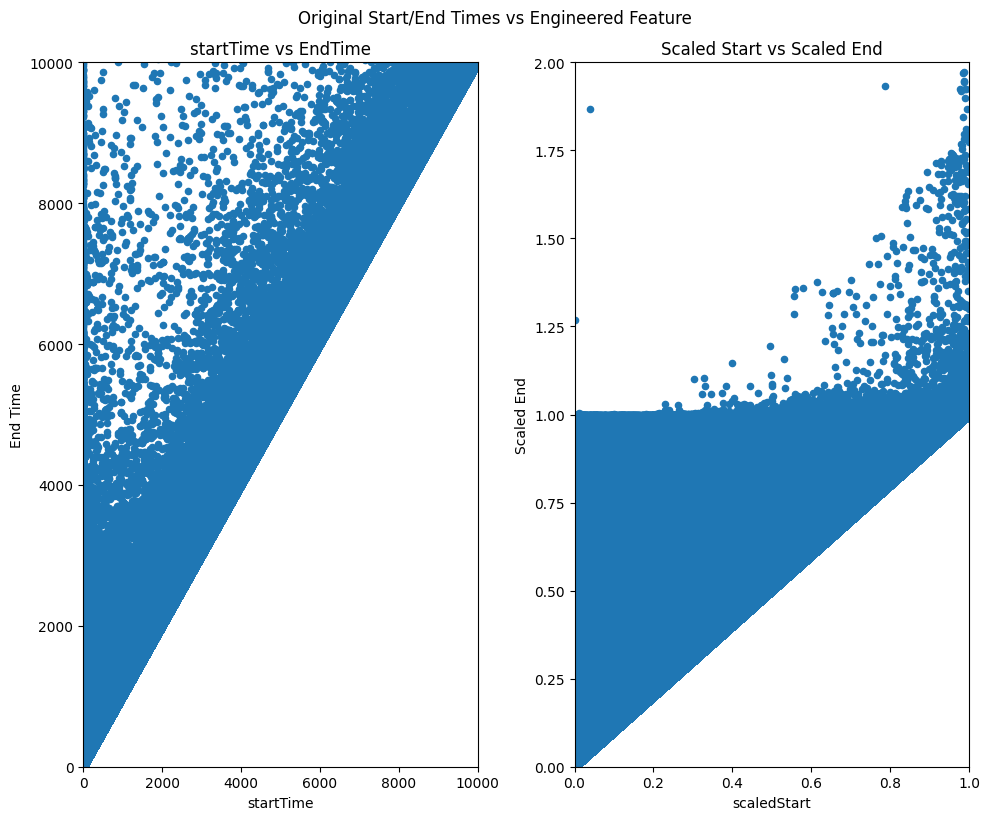

In [14]:
filtered = sb_data[(sb_data['startTime']<=sb_data['videoDuration'])]

for data, bound in zip([sb_data, filtered], [5,1]):
    fig, axes = plt.subplots(1, 2, figsize=(10, 8))
    
    data.plot(kind='scatter', x='startTime', y='endTime', ax=axes[0], legend=False)
    axes[0].set_title('startTime vs EndTime')
    axes[0].set_ylabel('End Time')
    # Cut off some of the outliers in the visualization
    axes[0].set_xlim(0,1e4)
    axes[0].set_ylim(0,1e4)
    
    data.plot(kind='scatter', x='scaledStart', y='scaledEnd', ax=axes[1], legend=False)
    axes[1].set_title('Scaled Start vs Scaled End')
    axes[1].set_ylabel('Scaled End')
    # Cut off some of the outliers in the visualization
    axes[1].set_xlim(0,bound)
    bound2 = 5 if bound==5 else 2
    axes[1].set_ylim(0,bound2)

    # Adjust layout for better spacing between plots
    plt.tight_layout()
    plt.suptitle('Original Start/End Times vs Engineered Feature', y=1.02)

    plt.savefig(f'./images/{plt.gca().get_title()}({0 if bound == 5 else 1}).png')
    plt.show()

We can see that the engineered features correlate between each other much better. However, we have segments with scaledStarts/Ends after the video ends. Let's investigate.

In [15]:
num_extraneous_start_times = sb_data[(sb_data['startTime']>sb_data['videoDuration'])].shape[0]
print(f'There are {num_extraneous_start_times} segments with start times after the video ends.')

sb_data[(sb_data['startTime']>sb_data['videoDuration']) & ~sb_data['hidden'] & ~sb_data['shadowHidden'] & (sb_data['votes']>0)][['videoID','startTime','endTime','category','actionType']].head()

There are 1802 segments with start times after the video ends.


,videoID,startTime,endTime,category,actionType
1017500,E0wW9RwpG7M,248,273,outro,skip
1381725,xy-ZGb3_VwY,591,648,sponsor,skip
1395298,5MYomuvrry4,1024,1109,sponsor,skip
1395347,5MYomuvrry4,1753,1768,sponsor,skip
1503616,nLWvxyRBS4Y,1863,1866,sponsor,skip


In [16]:
sb_data[(sb_data['startTime']>sb_data['videoDuration']) & (~sb_data['votes']>0)].shape[0]

226

226 segements that have a startTime after the video ends and isn't hidden and does have a positive vote.

There are a few explanations for these extraneous start times.

1. livestreams and premiers. These types of videos start with a countdown which can be quite long. If a user submits a segment during one of these, the segment will be off by the length of the countdown.
2. Edited videos. Under some situtations, YouTube lets creators cut out a portion of a video after it has gone live.
3. User error. Upon checking, sponsorblock does nothing to prevent a user from just manually entiring in times that start after the video ends. Though, since more recent updates does require the user to preview the segment before submission.
4. Malicious users. This seems unlikely since only a small fraction of these are shadowHidden which is done if a user is shadow banned.

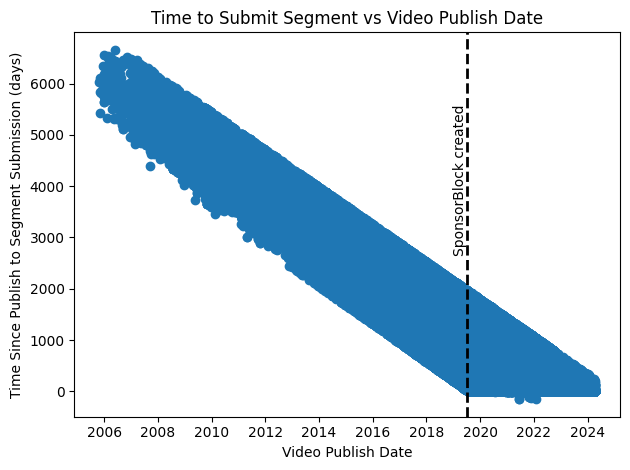

In [17]:
published = pd.to_datetime(sb_data['published'], unit='s')
timeToSubmission = sb_data['timeToSubmission']/3600/24

plt.scatter(published, timeToSubmission)
plt.axvline(pd.Timestamp('2019-07-12'), color='black', linestyle='--', linewidth=2)
plt.text(pd.Timestamp('2019-07-12'), plt.gca().get_ylim()[1]*0.8, 'SponsorBlock created',
         color='black', rotation=90, verticalalignment='top', horizontalalignment='right')

plt.xlabel('Video Publish Date')
plt.ylabel('Time Since Publish to Segment Submission (days)')
plt.title('Time to Submit Segment vs Video Publish Date')
plt.tight_layout()

plt.savefig(f'./images/{plt.gca().get_title()}.png')
plt.show()

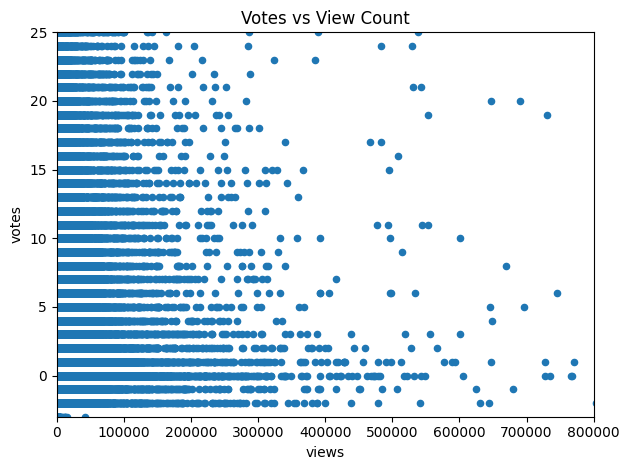

In [18]:
sb_data.plot(kind='scatter', x='views', y='votes')

plt.xlim(0, 800_000)
plt.ylim(-3,25)
plt.title('Votes vs View Count')
plt.tight_layout()

plt.savefig(f'./images/{plt.gca().get_title()}.png')
plt.show()

From here we can see that if segments are downvoted when very quickly get removed from the ability to be viewed. Though strangely more views doesn't appear to correlate with more votes.

In [19]:
popular_upvoted_data = sb_data[(sb_data['votes']>5) & (sb_data['views']>200_000)]
popular_upvoted_data[['videoID','channelID','category','actionType']].shape[0]

188

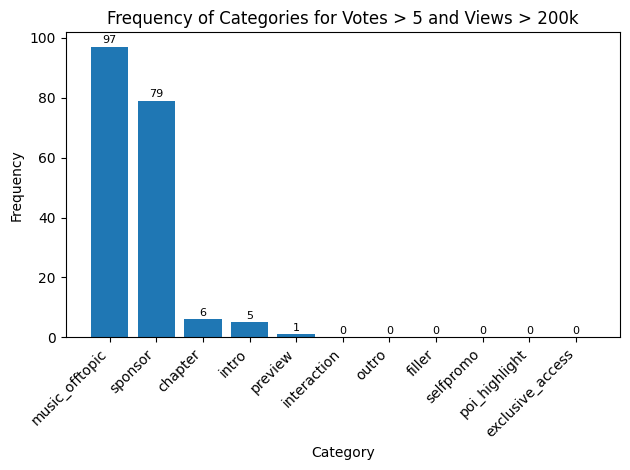

In [20]:
category_counts = popular_upvoted_data['category'].value_counts()

fig, ax = plt.subplots()
bars = ax.bar(category_counts.index, category_counts.values)

# Label each bar with the count
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, height + 0.005 * max(category_counts.values), str(height), ha='center', va='bottom', fontsize=8)

ax.set_xlabel('Category')
ax.set_ylabel('Frequency')
ax.set_title('Frequency of Categories for Votes > 5 and Views > 200k')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

plt.savefig(f'./images/high view count frequencies.png')
plt.show()

It appears that a lot of these high view count segments are music videos. Music videos appear here at a much higher frequency than in the general population. This would explan why people aren't necessarily as likely to vote on these high view counts as they may not be paying as much attention to YouTube.

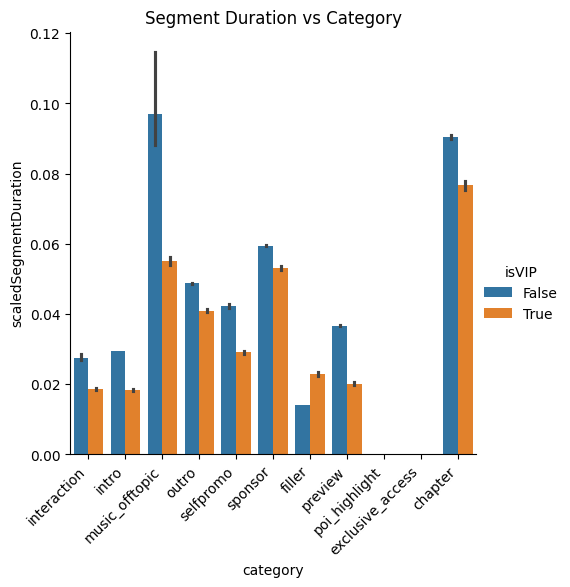

In [21]:
group_by = sb_data['actionType'].unique()

g = sns.catplot(data=sb_data, x='category', y='scaledSegmentDuration', hue='isVIP', kind='bar')
g.set_xticklabels(rotation=45, horizontalalignment='right')
plt.title('Segment Duration vs Category')

plt.savefig(f'./images/{plt.gca().get_title()}.png', pad_inches=0.1, bbox_inches='tight')
plt.show()

The above plot shows us that VIP users generally submit shorter segments.

## YouTube API Insights

First, we find the top 10 channels by segment count.

In [22]:
channel_counts = sb_data['channelID'].value_counts()
top_10_channel_ids = channel_counts.head(10)
top_10_df = sb_data[sb_data['channelID'].apply(lambda x: x in top_10_channel_ids)]

top_10_channel_ids_list = top_10_channel_ids.index.tolist()
channel_names = {}

Here we use the YouTube API to grab the channel names for those top 10 channels. This cell can be skipped if you don't have an API key.

In [23]:
from googleapiclient.discovery import build

API_KEY = os.getenv('YT_API_KEY')
youtube = build('youtube', 'v3', developerKey=API_KEY)

def get_channel_names(channel_ids):
    request = youtube.channels().list(
        part='snippet',
        id=','.join(channel_ids)
    )
    response = request.execute()

    channel_names = {}
    for item in response['items']:
        channel_names[item['id']] = item['snippet']['title']
    return channel_names

# Fetch the channel names for the top 10 channel IDs
channel_names = get_channel_names(top_10_channel_ids_list)

Finally, we plot segment count and segment type for those channels.

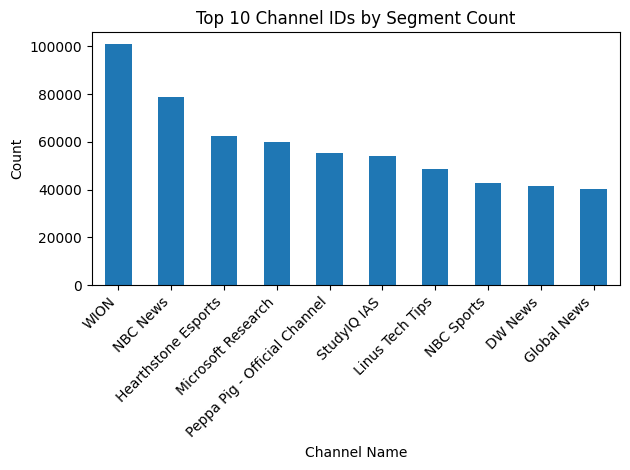

In [24]:
x_labels = [channel_names.get(cid, cid) for cid in top_10_channel_ids_list]

top_10_channel_ids.plot(kind='bar')

plt.xlabel('Channel Name')
plt.ylabel('Count')
plt.title('Top 10 Channel IDs by Segment Count')
plt.xticks(ticks=range(len(x_labels)), labels=x_labels, rotation=45, ha='right')
plt.tight_layout()

plt.savefig('./images/Top Channels By Segment Count.png')
plt.show()

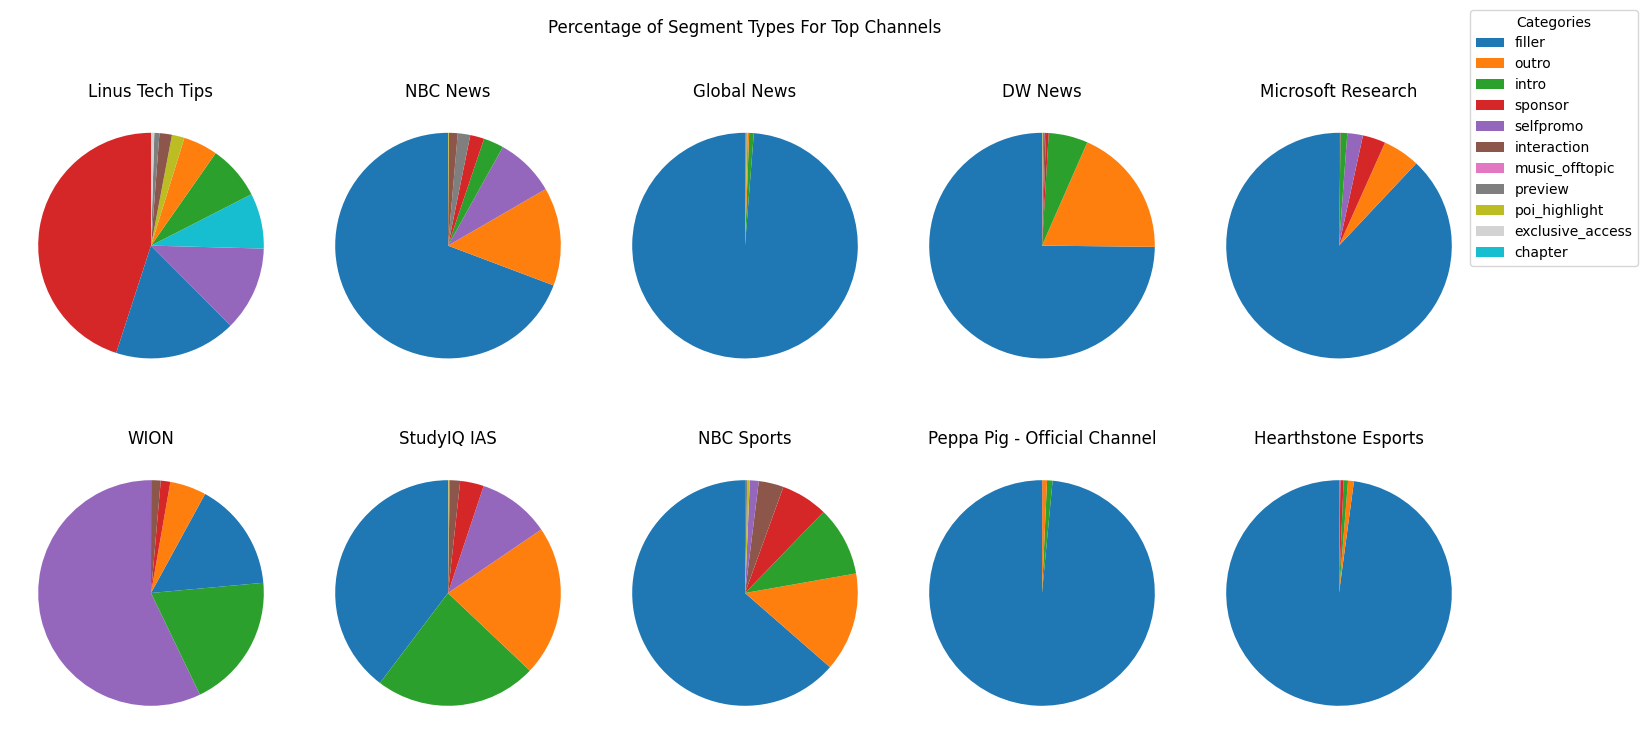

In [25]:
fig, axes = plt.subplots(2, 5, figsize=(15, 8))
axes = axes.flatten()

category_colors = {
    'filler': '#1f77b4',  # Blue
    'outro': '#ff7f0e',  # Orange
    'intro': '#2ca02c',  # Green
    'sponsor': '#d62728',  # Red
    'selfpromo': '#9467bd',  # Purple
    'interaction': '#8c564b',  # Brown
    'music_offtopic': '#e377c2',  # Pink
    'preview': '#7f7f7f',  # Gray
    'poi_highlight': '#bcbd22',  # Olive
    'chapter': '#17becf',  # Cyan
}

for i, channel_id in enumerate(top_10_df['channelID'].unique()):
    channel_data = top_10_df[top_10_df['channelID'] == channel_id]
    
    category_counts = channel_data['category'].value_counts()
    colors = [category_colors.get(category, '#d3d3d3') for category in category_counts.index]

    # Labels = None because the text gets too cluttered.
    wedges, texts = axes[i].pie(category_counts, labels=None, autopct=None, startangle=90, colors=colors)
    axes[i].set_title(f'{channel_names.get(channel_id, channel_id)}')

fig.legend(wedges, category_counts.index, title="Categories", loc="upper right", bbox_to_anchor=(1.1, 1))
plt.suptitle('Percentage of Segment Types For Top Channels')
plt.tight_layout()

plt.savefig('./images/Segment Types by Channel', pad_inches=0.1, bbox_inches='tight')
plt.show()